In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('language_data_with_dates.csv')
#codes where df[df['ascl-id'] == 0] need to be dealt with when thinking about dates

In [207]:
#A pie chart of the total language stats

#cast the Bytes column to int64
df = df[pd.to_numeric(df.Bytes,errors='coerce').notnull()]
df.Bytes = df['Bytes'].astype(str).astype(int)
df.sort_values(by='Bytes', ascending=False)

#group the rows by languages and sum on the Bytes column
lang = df.groupby('Language', as_index=False)['Bytes'].sum()

#Sed takes up a lot because one repository was
#using the file extension for their own data, not code
#Jupyter notebooks can be excluded, since they may contain 
#images which can artificially inflate the size
lang = lang[lang['Language'] != "sed"]
lang = lang[lang['Language'] != "Jupyter Notebook"]

#create a new column for the percent that language occupies
lang['% of total'] = lang.Bytes / lang.Bytes.sum() * 100

#filtering out irrelevant data
lang = lang[lang['% of total'] > 0.001]

lang = lang.sort_values(by='% of total', ascending=False)

#Pie chart time!

#this creates a pie chart without consolidating languages
'''
fig1, ax1 = plt.subplots()
ax1.pie(lang[lang.columns[1]], labels=lang[lang.columns[0]], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
'''

"\nfig1, ax1 = plt.subplots()\nax1.pie(lang[lang.columns[1]], labels=lang[lang.columns[0]], autopct='%1.1f%%',\n        shadow=True, startangle=90)\nax1.axis('equal')\n"

                                   Language      Bytes  % of total
0                                    Python  289004288   18.163067
1                                   Fortran  263411241   16.554619
2                                         C  244733012   15.380748
3                                       C++  218327962   13.721268
4   All other languages, each < 2% of total  191282135   12.021518
5                                      HTML   95307284    5.989782
6                                      Java   63113450    3.966494
7                                     Shell   54842464    3.446687
8                                      Ruby   53948642    3.390513
9                                       TeX   44539192    2.799157
10                             OpenEdge ABL   36927794    2.320803
11                                      IDL   35571569    2.235568


(-1.1125275989249963,
 1.1061580341722685,
 -1.101081319684025,
 1.1000514928489695)

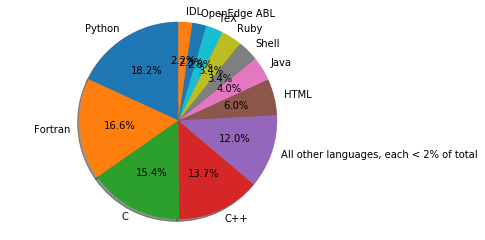

In [208]:
#Now, create a pie chart with languages <2% consolidated into one "Other Languages" entry

#calculate percent sum
#calculate bytes sum
#filter lang dataframe for > 2%
#create new dataframe row of sum data and append to filtered dataframe

find_sum = lang[lang['% of total'] < 2].sum()

pct_sum = find_sum['% of total']
bytes_sum = find_sum['Bytes']

new_row = ["All other languages, each < 2% of total",
          bytes_sum,
          pct_sum]

most = lang[lang['% of total'] >= 2].reset_index().drop(columns=['index'])
most.loc[len(most)] = new_row
most = most.sort_values(by='% of total', ascending=False).reset_index().drop(columns=['index'])
print(most)


fig2, ax2 = plt.subplots()
ax2.pie(most[most.columns[1]], labels=most[most.columns[0]], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')

In [209]:
#function to return the correct year depending on the first 2 digits of the ascl-id
def ascl_year(row):
    year = str(row['ascl-id'])[0:2]
    try:
        year = int(year)
    except:
        year = float(year)
    if year > 89:
        return 1900+int(year)
    elif year == 0:
        return None
    else:
        return 2000+int(year)

#now, a function to generate the repo year
def repo_year(row):
    return row['repo_date'][0:4]

df['ascl_year'] = df.apply (lambda row: ascl_year(row), axis=1)
df.ascl_year = df.ascl_year.fillna(0.0).astype(int)
df['repo_year'] = df.apply (lambda row: repo_year(row), axis=1)
df.repo_year = df.repo_year.fillna("0").astype(int)

In [210]:
#link to how to get stacked area chart
#https://python-graph-gallery.com/255-percentage-stacked-area-chart/

#x axis - year
#y axis - percentage of the total
#for each language, we need an array of languages over years

#let's only take a look at the most popular languages

#each language is a separate row
#each column is a year, and each cell represents the bytes of that language in that year

repo_years = np.sort(df.repo_year.unique())

#can use either of these, or define your own subset to get different information
most_bytes_langs = ['Java', 'C', 'C++', 'Python', 'R', 'Fortran', 'Ruby', 'HTML', 'Shell', 'Others']
language_subset = ['Java', 'C', 'C++', 'Python', 'Ruby', 'Shell']

requested_langs = language_subset
repo_df = pd.DataFrame({'Language': requested_langs})

def bytes_that_year(row, year):
    #print('trying ' + row['Language'] + ' in year ' + str(year))
                        
    if row['Language'] == 'Others':
      #sum up all the non-request_langs bytes
        return df[ ~(df['Language'].isin(requested_langs)) & (df['repo_year'] == year)]['Bytes'].sum()
    lang = row['Language']
    
    try:
        return df[df['repo_year'] == year].groupby('Language').sum().loc[lang]['Bytes']
    except:
        return 0

    
#for each year in repo_years, create a column
# each cell will be the number of bytes in that year for that language    

for year in repo_years:
    #create columns for the total number of bytes
    arr = repo_df.apply (lambda row: bytes_that_year(row, year), axis=1)
    #col_name = str(year) + " bytes"
    #repo_df[col_name] = arr
    total_bytes = arr.sum()
    pct_col_name = str(year) #+ " pct"
    repo_df[pct_col_name] = arr.divide(total_bytes)

#display(repo_df)


#need to get the whole df sideways to make the stackchart easy
repo_df = repo_df.T
new_header = repo_df.iloc[0] 
repo_df = repo_df[1:]
repo_df.columns = new_header

repo_df.columns.name = 'Year'
repo_df = repo_df.apply(pd.to_numeric, errors='coerce')
display(repo_df)


Year,Java,C,C++,Python,Ruby,Shell
2008,0.000000,0.578053,0.058089,0.361369,0.000000,0.002489
2009,0.000000,0.001607,0.417636,0.566579,0.000000,0.014178
2010,0.000000,0.009153,0.270674,0.716161,0.000000,0.004011
2011,0.000000,0.139155,0.024259,0.786091,0.000000,0.050494
2012,0.017804,0.456689,0.140129,0.333853,0.000000,0.051525
2013,0.240166,0.396410,0.165945,0.167947,0.014956,0.014577
2014,0.131448,0.373647,0.163997,0.316473,0.000000,0.014435
2015,0.001600,0.219418,0.209717,0.291359,0.269503,0.008403
2016,0.032361,0.205968,0.234869,0.489617,0.015521,0.021665
2017,0.000000,0.137536,0.425045,0.236715,0.000003,0.200702


In [211]:
#Now, do the same for ascl_year instead of github repo_year
ascl_years = np.sort(df.ascl_year.unique())

#drop all the codes where the ascl_year is 0 (they have no ascl-id)
df = df[df['ascl_year'] != 0]

ascl_df = pd.DataFrame({'Language': requested_langs})


def bytes_that_year_ascl(row, year):
    #print('trying ' + row['Language'] + ' in year ' + str(year))
                        
    if row['Language'] == 'Others':
      #sum up all the non-request_langs bytes
        return df[ ~(df['Language'].isin(requested_langs)) & (df['ascl_year'] == year)]['Bytes'].sum()
    lang = row['Language']
    
    try:
        return df[df['repo_year'] == year].groupby('Language').sum().loc[lang]['Bytes']
    except:
        return 0

for year in repo_years:
    #create columns for the total number of bytes
    arr = ascl_df.apply (lambda row: bytes_that_year_ascl(row, year), axis=1)
    total_bytes = arr.sum()
    pct_col_name = str(year) #+ " pct"
    ascl_df[pct_col_name] = arr.divide(total_bytes)

ascl_df = ascl_df.T
new_header = ascl_df.iloc[0] 
ascl_df = ascl_df[1:]
ascl_df.columns = new_header

ascl_df.columns.name = 'Year'
ascl_df = ascl_df.apply(pd.to_numeric, errors='coerce')
display(ascl_df)


Year,Java,C,C++,Python,Ruby,Shell
2008,0.000000,0.578053,0.058089,0.361369,0.000000,0.002489
2009,0.000000,0.001634,0.424616,0.559335,0.000000,0.014415
2010,0.000000,0.018108,0.742881,0.235232,0.000000,0.003779
2011,0.000000,0.132769,0.024802,0.790838,0.000000,0.051591
2012,0.018174,0.463017,0.135944,0.330277,0.000000,0.052587
2013,0.245234,0.394822,0.168273,0.161516,0.015271,0.014883
2014,0.135650,0.384275,0.168759,0.296789,0.000000,0.014526
2015,0.001723,0.214573,0.225117,0.259376,0.290272,0.008939
2016,0.033668,0.212853,0.236641,0.478205,0.016147,0.022486
2017,0.000000,0.137341,0.412399,0.233996,0.000003,0.216262


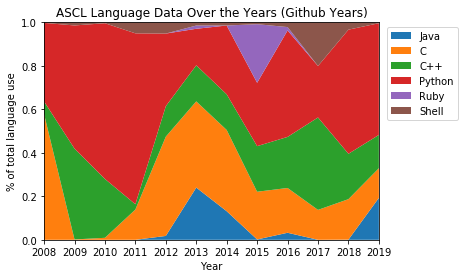

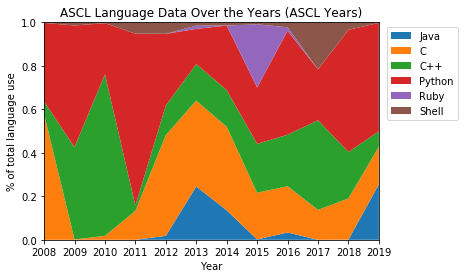

In [212]:
#now, let's create the stacked area chart

plt.stackplot( repo_df.index.values, repo_df.T )
plt.legend(bbox_to_anchor=(1.25, 1), labels=repo_df.columns)
plt.margins(0,0)
plt.title('ASCL Language Data Over the Years (Github Years)')
plt.xlabel('Year')
plt.ylabel('% of total language use')
plt.show()


plt.stackplot( ascl_df.index.values, ascl_df.T )
plt.legend(bbox_to_anchor=(1.25, 1), labels=ascl_df.columns)
plt.margins(0,0)
plt.title('ASCL Language Data Over the Years (ASCL Years)')
plt.xlabel('Year')
plt.ylabel('% of total language use')
plt.show()